## Data 602 Project:  NOAA Tornado Data
#### Author: Aaron Grzasko
#### Date: 5/26/2017

## Introduction

Tornadoes are terrifying physical phenenoma that can inflict billions of dollars in property damage and claim scores of human lives.  
  
While the potential for devastation is real, I often wonder whether the threat--at portrayed by local and national news media--is a bit overblown (no pun intended).  
  
In this project, I will informally explore historical US Tornado activity using storm data published by the National Oceanic Atmospheric Administration (NOAA).  

Here are questions I will address in my analysis:  

- What counties and states have experienced the most tornadic activity?
- Where do most tornado fatalities occur (e.g. in buildings, cars, outside, etc)?  
- What is the probability of a fatality, given a tornadic event?
- What is the average number of lives lost, given a fatal tornado?  
- What is the distribution of tornado types (Enhanced Fujita Scale EF0 - EF5)?
- Are the number of tornadoes in the U.S. increasing over time?  I'll try to answer this question using both visualization and a linear model.   
  
Finally, I will also use a Random Forest Classifer Model to predict a tornado's assigned Fujita Scale, given a set of indirectly related, numerical attributes.    
 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import urllib
import re
import gzip
from ipywidgets import interact
from IPython.display import display, HTML
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# matlab
%matplotlib inline
import matplotlib.pyplot as plt

# plotly
import plotly 
from plotly.graph_objs import *
import plotly.plotly as py
plotly.tools.set_credentials_file(username='spitakiss', api_key='xeac7OwHx0ovp7g5JDQE') # primary api key

# use this seconday api key if maximum limit of api requests for primary key have been met
# plotly.tools.set_credentials_file(username='agrzasko', api_key='XUEfJR7hQZWnYl5JgfsR') # secondary api key if exceed

## Read Data


First, let's use Beautiful Soup and regex to find relevant, zipped csv files on the NOAA website.  We'll limit our search to files for the years 1997 through 2016.

In [2]:
myurl = 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/' 
r = urllib.urlopen(myurl)

soup = BeautifulSoup(r.read(),"lxml")

myfiles = []
for link in soup.find_all(text=re.compile("StormEvents.*d(199[7-9]|200[0-9]|201[0-6]).*gz$")):
    myfiles.append(link)    
r.close()

Download and unzip all files.

In [3]:
for name in myfiles:
    # download script
    urllib.URLopener().retrieve(myurl+name,name)
    
    # unzip procedure
    in_file = gzip.GzipFile(name, 'rb')
    s = in_file.read()
    in_file.close()
    out_file = file(name[:-3], 'wb')  # exclude ".gz" ending when naming output file
    out_file.write(s)
    out_file.close()

There are three different file types.  I'll store each file type in a separate dataframe. 


In [4]:
# subset the 3 different file formats
detail_files = [x[:-3] for x in myfiles if 'details' in x]
loc_files = [x[:-3] for x in myfiles if 'location' in x]
fat_files = [x[:-3] for x in myfiles if 'fatalities' in x]

In [5]:
# create 3 panda dataframes, 1 for each file type
for f in ["detail_files","loc_files","fat_files"]:
    df_list =[]
    for name in sorted(eval(f)):
        df_list.append(pd.read_csv(name))
    exec("%s=%s"%(f+"_df", "pd.concat(df_list)"))


/anaconda/envs/rclone/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda/envs/rclone/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.



Next, limit the storm type to Tornadoes only.  Finally, join together the tables as necessary to complete the analysis.  

*Note: in my original project proposal, I discussed an optional exercise where I would store the raw data in an SQL databatase.  I decided against implementing this step, as pandas has proven to be very capable at performing joins and processing the entire 20 years worth of NOAA data.*

In [6]:
# limit detail files to tornadic events only; other files do not directly list storm type
tor_detail = detail_files_df[detail_files_df.EVENT_TYPE == 'Tornado']

In [7]:
# inner join of tornado detail and location files
# to make sure we're pulling in locations related to tornadoes only
tor_det_loc = pd.merge(tor_detail, loc_files_df, on=['EPISODE_ID','EVENT_ID'], how='inner')

# inner join tornado details and fatality dataframes
# this ensures that we're limiting to fatalities causes by tornadoes
tor_det_fat = pd.merge(tor_detail, fat_files_df, how='inner')

## Exploratory Analysis

**Top States and Counties for Tornadic Activity: Summary Tables**

Below are the top 10 areas for tornadoes, both at the state and county levels: 

In [8]:
# find top 10 states by tornado event_id count
state_ct = pd.DataFrame({'count': tor_detail.groupby(["STATE"]).size()}).reset_index()
state_ct = state_ct.sort_values(by='count',ascending=False)

# find top 10 counties by tornado event_id count
county_ct = pd.DataFrame({'count': tor_detail.groupby(["CZ_NAME","STATE"]).size()}).reset_index()
county_ct = county_ct.sort_values(by='count',ascending=False)


# Plot side-by-side STATE and COUNTY top 10 output
# see: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side/42866792
def multi_column_df_display(list_dfs, cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

list_dfs = []
list_dfs.append(state_ct.head(10))
list_dfs.append(county_ct.head(10) )
multi_column_df_display(list_dfs)

,STATE,count
44,TEXAS,2866
16,KANSAS,2063
36,OKLAHOMA,1504
0,ALABAMA,1328
13,ILLINOIS,1289
24,MISSISSIPPI,1189
15,IOWA,1177
25,MISSOURI,1132
9,FLORIDA,1132
27,NEBRASKA,1128


Most of the states in the top 10 list were expected, as tornadic activity in the central plains and southeastern states frequently makes the national news.  I was mildly surpised by two states in the list: Illinois and Florida.  
  
On the other hand, I was shocked to see five Colorado localities in the top 10 list for tornadoes by county.  

**Plot of Top States for Tornadic Activity**

See below for a plot total tornadic events, by state, over the entire historical period:

In [9]:
# convert states to two letter abbreviation: plotly doesn't recognize full state name
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

tor_detail.iloc[:,tor_detail.columns.get_loc("STATE")] = \
    tor_detail.iloc[:,tor_detail.columns.get_loc("STATE")].str.title().map(us_state_abbrev)



/anaconda/envs/rclone/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [10]:
# plot tornadic activity by state

df = pd.DataFrame({'count': tor_detail.groupby(["STATE"]).size()}).reset_index()

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(221, 205, 22)'],[0.4, 'rgb(198, 140, 23'],\
            [0.6, 'rgb(186, 104, 50)'],[0.8, 'rgb(211, 92, 74)'],[1.0, 'rgb(206,14,14)']]

df['text'] = df['STATE']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['STATE'],
        z = df['count'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of Tornadoes")
        ) ]

layout = dict(
        title = 'Tornadoes by State<br>(Total Historical Period)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='tor-by-state' )

**Location/Structure at Time of Death**

A commonly held belief is that mobile homes are much more dangerous than traditional dwelling structures during severe weather events.  I cannot directly calculate the probability of a tornado-related fatality, given a mobile home location, but with the provided data, I can look at the raw fatality count by location type.   

In [11]:
# summary dataframe of tornado fatalities
fat_by_loc = pd.DataFrame({'count': tor_det_fat.groupby(["FATALITY_LOCATION"]).size()}).reset_index()
fat_by_loc = fat_by_loc.sort_values(by='count',ascending=False)

#  add cumulative sums and percentages
fat_by_loc['cum_sum'] = fat_by_loc['count'].cumsum()
fat_by_loc['perc'] = fat_by_loc['count']/fat_by_loc["count"].sum()
fat_by_loc['cum_perc'] = fat_by_loc["cum_sum"]/fat_by_loc["count"].sum()
fat_by_loc.sort_values(by='count',ascending=False)
fat_by_loc

,FATALITY_LOCATION,count,cum_sum,perc,cum_perc
7,Mobile/Trailer Home,628,628,0.373143,0.373143
10,Permanent Home,610,1238,0.362448,0.735591
15,Vehicle/Towed Trailer,137,1375,0.081402,0.816993
11,Permanent Structure,80,1455,0.047534,0.864528
14,Unknown,80,1535,0.047534,0.912062
9,Outside/Open Areas,51,1586,0.030303,0.942365
1,Business,34,1620,0.020202,0.962567
3,Church,19,1639,0.011289,0.973856
12,School,16,1655,0.009507,0.983363
6,Long Span Roof,13,1668,0.007724,0.991087


Sure enough, we see more fatalities in mobile homes compared to any other location.  
 
It may make sense to roll up the categories above into higher-level aggregrations.  For instance, schools, churches, and traditional homes are relatively secure/permanent structures.  On the other hand, vehicles, construction equipment, trailers, and mobile homes are less permanent.  Individuals who take shelter outdoors are, of course, afforded the least amount of protection.  
  
Let's review the fatality data with the high-level category roll-ups:

In [12]:
# Make new column that combines Fatality locations into higher level aggregration
def f(row):
    if row['FATALITY_LOCATION'] in ["Permanent Home","Permanent Structure","School","Business", "Church"] :
        val = "Perm"
    elif row['FATALITY_LOCATION'] in ["Other","Unknown"] :
        val = "Other"
    elif row['FATALITY_LOCATION'] in ["Ball Field","Golfing","Long Span Roof","Camping",\
                                      "Under Tree","Boating","In Water","Outside/Open Areas"]:
        val = "Outside"
    else:
        val = "Non Perm"
    return val

fat_by_loc['LOC_CLASS'] = fat_by_loc.apply(f, axis=1)

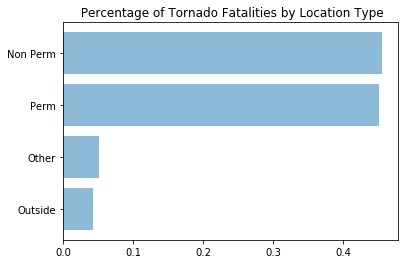

In [13]:
# horizontal bar chart of tornado fatalites by Location Class
grouper =  fat_by_loc.groupby("LOC_CLASS")['perc'].sum().reset_index().sort_values(by="perc")
objects = grouper["LOC_CLASS"]
percents = grouper["perc"]
y_pos = np.arange(len(objects))
plt.barh(y_pos, percents, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.title(' Percentage of Tornado Fatalities by Location Type')

plt.show()


As expected, The percentage of fatalities is greatest in the non-permanent/less secure structures, although the percentage for permanent structures is very close.

**Probability of a Tornado Being Fatal**

How likely is it that at least one person will die, given a tornadic event?  Let's take a look.  

*Let X = Number of Deaths*  

*Let $\theta$ = Tornadic Event*  

Find $P(X \geq 1~|~\theta)$

In [14]:
# number of fatal events:  only fatal events are provided in the fatalities table
event_fatal = len(tor_det_fat["EVENT_ID"].unique())
print "Number fatal events: "+ str(event_fatal)

# number of tornadic events
tot_events = len(tor_detail["EVENT_ID"].unique())
print "Number of tornadic events: "+ str(tot_events)

# P (fatility >= 1 | Event)
print ("Prob of at least one fatality, given tornado: ") + str(round(float(event_fatal)/float(tot_events),4)*100)+"%"

Number fatal events: 516
Number of tornadic events: 27426
Prob of at least one fatality, given tornado: 1.88%


From the calculations above, we see that the probability of a tornado event resulting in a fatality is low: less than 1 out of 50 over the 20 year historical period.

**Average Number of Deaths, Given Fatal Tornado**

Here is one more interesting fatality statistic from the 20 year tornado history:

*Let X = Number of Deaths*  

*Let $\theta$ = Tornadic Event*  
  
*Let $\lambda$ = Fatal Event*. 
  
Find $E(X~|~\theta,\lambda)$

In [15]:
# number of fatalities
num_fat = len(tor_det_fat["FATALITY_ID"].unique())
print "total fatalities over entire period: " + str(num_fat)

# Avg number of fatalities, given at least one death
avg_fat_gvnfat = float(num_fat) / event_fatal
print "average number of fatalities, given at least one death: " + str(round(avg_fat_gvnfat,2))

total fatalities over entire period: 1679
average number of fatalities, given at least one death: 3.25


**Distribution of Tornado Types**

One common measure of a tornado's intensity is its rating on the Enhanced Fujita Scale.  Let's take a look at the distribution of the tornado ratings: 

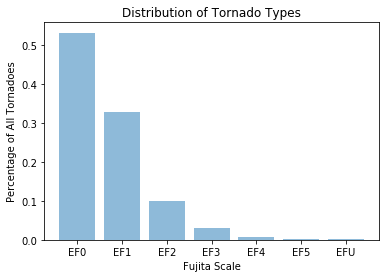

In [16]:
# data 
fujita_df = pd.DataFrame(tor_detail, columns=["YEAR","TOR_F_SCALE"])
fujita_df = fujita_df[fujita_df['YEAR'] >= 2008] # only include years after 2007 due to F scale chanages
fujita_df = pd.DataFrame({'count': fujita_df.groupby(["TOR_F_SCALE"]).size()}).reset_index()
fujita_df["percent"] = fujita_df["count"] / fujita_df["count"].sum()
fujita_df

# plot
y_pos = np.arange(len(fujita_df["TOR_F_SCALE"]))
plt.bar(y_pos, fujita_df["percent"],align='center', alpha=0.5)
plt.xticks(y_pos, fujita_df["TOR_F_SCALE"])
plt.xlabel("Fujita Scale")
plt.ylabel("Percentage of All Tornadoes")
plt.title("Distribution of Tornado Types")
plt.show()

From the plot above, we see that the lower intensity EF0 and EF1 tornadoes comprise more than 80% of all tornadoes.

**Trend in Tornadic Activity Over Time**

Is there a distinct trend in either the number of tornadoes or the geographic location of tornado occurences?  Let's plot an interactive graph with a slider so we can visualize tornado activity over the last 20 years. 

In [17]:
# plot of tornadoes by Year using latitude/longitude coordinates
# use sliders to view by year

df = pd.DataFrame({'count': tor_det_loc.groupby(["LATITUDE","LONGITUDE","YEAR"]).size()}).reset_index()

scl =[[0, 'rgb(166,206,227)'], [0.25, 'rgb(31,120,180)'], [0.45, 'rgb(178,223,138)'], \
      [0.65, 'rgb(51,160,44)'], [0.85, 'rgb(251,154,153)'], [1, 'rgb(227,26,28)']],

def plot_it(step):
    
    data = [ dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = df[df.YEAR == step]["LONGITUDE"],
            lat = df[df.YEAR == step]["LATITUDE"],
            #text = df['text'],
            mode = 'markers',
            marker = dict( 
                size = 6, 
                opacity = 0.8,
                reversescale = False,
                autocolorscale = True,
                symbol = 'circle',
                line = dict(
                    width=1,
                    color='rgba(102, 102, 102)'
                ),
                colorscale = scl,
                cmin = 0,
                color = df[df.YEAR == step]['count'],
                cmax = df[df.YEAR == step]['count'].max(),
                
            ))]

    layout = dict(
            title = 'Number of Tornados<br>by Latitude/Longitude',
            colorbar = False,   
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showland = True,
                landcolor = "rgb(250, 250, 250)",
                subunitcolor = "rgb(217, 217, 217)",
                countrycolor = "rgb(217, 217, 217)",
                countrywidth = 0.5,
                subunitwidth = 0.5        
            ),
        )

    fig = dict( data=data, layout=layout )
    return py.iplot( fig, validate=False, filename='tornadic_act_lat' )

interact(plot_it, step=(1997,2016))

<function __main__.plot_it>

The interactive graph on my computer was a bit sluggish, and didn't provide a clear picture of tornado frequency or geographic trends over time.  It may be more fruitful to look at a plot of all 20 years together:

In [18]:
# Multi Plots
import plotly.plotly as py
import pandas as pd
df = pd.DataFrame({'count': tor_det_loc.groupby(["LATITUDE","LONGITUDE","YEAR"]).size()}).reset_index()


data = []
layout = dict(
    title = 'Tornadoes Per Year <br> by Latitude/Longitude Coordinates',
    # showlegend = False,
    autosize = False,
    width = 1000,
    height = 900,
    hovermode = False,
    legend = dict(
        x=0.7,
        y=-0.1,
        bgcolor="rgba(255, 255, 255, 0)",
        font = dict( size=11 ),
    )
)
years = df['YEAR'].unique()

for i in range(1997,2017):
    geo_key = 'geo'+str(i) 
    lons = list(df[ df['YEAR'] == i]['LONGITUDE'])
    lats = list(df[ df['YEAR'] == i]['LATITUDE'])
    # Tornado Data
    data.append(
        dict(
            type = 'scattergeo',
            showlegend=False,
            lon = lons,
            lat = lats,
            geo = geo_key,
            name = i,
            marker = dict(
                color = "rgb(0, 0, 255)",
                opacity = 0.5
            )
        )
    )
    # Year markers
    data.append(
        dict(
            type = 'scattergeo',
            showlegend = False,
            lon = [-78],
            lat = [47],
            geo = geo_key,
            text = [i],
            mode = 'text',
        )
    )
    layout[geo_key] = dict(
        scope = 'usa',
        showland = True,
        landcolor = 'rgb(229, 229, 229)',
        showcountries = False,
        domain = dict( x = [], y = [] ),
        subunitcolor = "rgb(255, 255, 255)",
    )


z = 1997
COLS = 4
ROWS = 5
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z) 
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1
        if z > 2016:
            break

fig = { 'data':data, 'layout':layout }
py.iplot( fig, filename='mult_plot_tor', height=900, width=1000 )


Surprisingly, I still don't see an obvious trend over time.  The charts indicate a relatively consistent pattern of high activity in the central plains, and perhaps to a lesser extent, in the Mid Atlantic and Southeastern regions.  The west coast experienced somewhat mild tornadic activity throughout the entire period.

## Model: Linear Trend in Tornadoes per Year

In the previous section, I noted that there were no discernible, visible patterns in tornado frequency or geographic shifts over time.  Let's now use a simple OLS model to establish a pattern in the number of tornadic events over time.

slope parameter: -7.60601503759
intercept parameter: 16632.7691729
r-squared value: 0.020677026131
p-value of slope:  0.545297939841


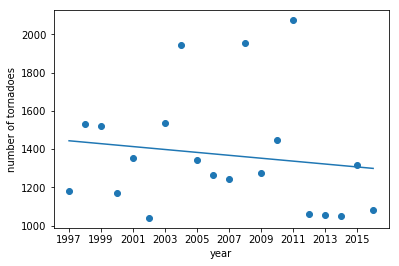

In [19]:
# fit OLS linear model to number of tornadoes per year

ols_df = pd.DataFrame({'count': tor_detail.groupby(["YEAR"]).size()}).reset_index()

slope, intercept, r_value, p_value, std_err = stats.linregress(ols_df["YEAR"],ols_df["count"])
print "slope parameter: " + str(slope)
print "intercept parameter: " + str(intercept)
print "r-squared value: " + str(r_value**2)
print "p-value of slope:  " + str(p_value)
  
# scatter plot
plt.scatter(ols_df["YEAR"],ols_df["count"])

# overlay OLS line
plt.plot(np.unique(ols_df["YEAR"]), np.poly1d(np.polyfit(ols_df["YEAR"], ols_df["count"], 1))(np.unique(ols_df["YEAR"])))

# formatting
plt.xticks(range(1997,2017,2))
plt.ylabel('number of tornadoes')
plt.xlabel('year')
plt.show()  
    

Our fitted OLS model indicates a slope of -7.6, which translates to a decrease in the number of tornadoes by about 8 per year.  However, the fit of this model is very poor:  the R-squared value is extremely low (2%), the p-value for the slope parameter is high (55%).  The scatter plot of the OLS line against the actual data only reinforces the idea that our model is a poor fit. 

## Model:  Predicting Fujita Scale

According to Wikipedia, the tornado Fujita scale is "based primarily on the damage tornadoes inflict on human-built structures and vegetation."  
  
I thought it would be an interesting exercise to try to predict the Fujita scale, given a set of features not directly related to physical damages.  
  
In the following scripts, I train a random forest model to make the prediction, using 80% of the available.  
I then test the accuracy of the model using the remaining 20% of the data.

accuracy rate:0.6625


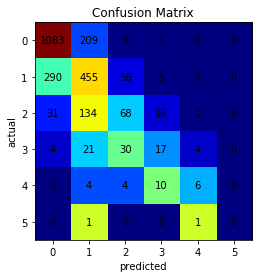

In [20]:
# adapting/modifying procedures outlined here: http://blog.yhat.com/posts/random-forests-in-python.html

# set up reduced dataframe with target variable and features
mycols = ['TOR_F_SCALE','DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_DIRECT','TOR_LENGTH','TOR_WIDTH',\
          'YEAR','STATE_FIPS']
# initial dataframe
mydf = pd.DataFrame(tor_detail, columns=mycols)

# only include years after 2007, when rating moved to Enhanced Fujita Scale from standard Fujita scale
mydf = mydf[mydf['YEAR']>=2008]

# exclude unknown tornado types
mydf = mydf[mydf["TOR_F_SCALE"]!='EFU']

# allowed tornado scale classifications
target_class = np.array(mydf["TOR_F_SCALE"].unique())

# randomly allocate between training and test sets, using 80/20 split
np.random.seed(2001)
mydf['is_train'] = np.random.uniform(0, 1, len(mydf)) <= .80

# initialize training and test data sets
train, test = mydf[mydf['is_train']==True], mydf[mydf['is_train']==False]

# define feature columns
features = mydf.columns[1:]

# Train Random Forest Classifer
model = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['TOR_F_SCALE'])
model.fit(train[features], y)

# predictions
preds = target_class[model.predict(test[features])]

# calculate accuracy rate
accuracy = sum(preds == test['TOR_F_SCALE']) / float(preds.size)
print "accuracy rate:" + str(round(accuracy,4))

# confusion matrix plot: see https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
conf_mat = confusion_matrix(test['TOR_F_SCALE'],preds)
norm_conf = []
for i in conf_mat:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')
width, height = conf_mat.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_mat[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')


The accuracy of the model on the test data is roughly 66%, which is significantly better than randomly guessing, but is still not great.  In the confusion matrix plot above, I noticed that the model has a tendency to understimate the Fujita Scale.  Also, the model does much better at predicting the scales of lower grade tornadoes(i.e. EF0 and EF1).  This is an expected result, as there are more tornado data points available at the lower end of the Fujita scale--refer to my earlier exploration on the distribution of tornado types for more details.  

## References

**Unzipping**
- https://stackoverflow.com/questions/20635245/using-gzip-module-with-python  
- https://stackoverflow.com/questions/1316357/zlib-decompression-in-python  
  
**Plotly Tutorials**
- [Subplots](https://plot.ly/python/map-subplots-and-small-multiples/)  
- [Scatter Plots with Maps](https://plot.ly/python/scatter-plots-on-maps/)  
- [Choropleth Maps](https://plot.ly/python/choropleth-maps/)  
  
  
**Interact Function**
- [Interact basics](http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html)
- [Interact with Plotly](https://stackoverflow.com/questions/36280857/creating-a-dropdown-menu-in-plotly-from-pandas)
  
**Side-by-Side Dataframe Printing**. 
- https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side/42866792  
  
**OLS in scipy.stats**. 
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

**Classifier Model**. 
- [Random Forest Python](http://blog.yhat.com/posts/random-forests-in-python.html)
- [Confusion Matrix](https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix)  
  
**State Abbreviations**. 
- https://gist.github.com/rogerallen/1583593

**NOAA**
- [Storm Database main page](https://www.ncdc.noaa.gov/stormevents/). 
- [CSV file Location](https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/)
- [File Layout](https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Export-Format.docx)